# Fetal Health Metrics

## Introduction

#### Context
Reduction of child mortality is reflected in several of the United Nations' Sustainable Development Goals and is a key indicator of human progress.
The UN expects that by 2030, countries end preventable deaths of newborns and children under 5 years of age, with all countries aiming to reduce under‑5 mortality to at least as low as 25 per 1,000 live births.

Parallel to notion of child mortality is of course maternal mortality, which accounts for 295 000 deaths during and following pregnancy and childbirth (as of 2017). The vast majority of these deaths (94%) occurred in low-resource settings, and most could have been prevented.

In light of what was mentioned above, Cardiotocograms (CTGs) are a simple and cost accessible option to assess fetal health, allowing healthcare professionals to take action in order to prevent child and maternal mortality. The equipment itself works by sending ultrasound pulses and reading its response, thus shedding light on fetal heart rate (FHR), fetal movements, uterine contractions and more.

<br>

### Data
This dataset contains 2126 records of features extracted from Cardiotocogram exams, which were then classified by three expert obstetritians into 3 classes:

- Normal (1)
- Suspect (2)
- Pathological (3)

[Data Source](https://www.kaggle.com/andrewmvd/fetal-health-classification?select=fetal_health.csv)
[Data Authors](https://onlinelibrary.wiley.com/doi/10.1002/1520-6661(200009/10)9:5%3C311::AID-MFM12%3E3.0.CO;2-9)

<br>

### Tasks
1) Create a multiclass model to classify the state of fetus. <br>
2) Find best evaluation metrics. 


In [93]:
# Load in libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel


### Examine Data

In [42]:
# load in data
fetal_data = pd.read_csv('C:/Users/prewi/OneDrive/Documents/Projects-PostSchool/Fetal_Health/fetal_health.csv')


In [43]:
fetal_data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [44]:
fetal_data.shape

(2126, 22)

In [45]:
fetal_data.dtypes

baseline value                                            float64
accelerations                                             float64
fetal_movement                                            float64
uterine_contractions                                      float64
light_decelerations                                       float64
severe_decelerations                                      float64
prolongued_decelerations                                  float64
abnormal_short_term_variability                           float64
mean_value_of_short_term_variability                      float64
percentage_of_time_with_abnormal_long_term_variability    float64
mean_value_of_long_term_variability                       float64
histogram_width                                           float64
histogram_min                                             float64
histogram_max                                             float64
histogram_number_of_peaks                                 float64
histogram_

In [46]:
fetal_data.isna().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

### Training Feature Selection
Data is entirely numeric with no missing values. Many of the recorded values are statistical records of observations.  For these tasks, only using features for classification which could be easily available or determined in a clinical setting. For example, a histogram is not considered easily available in a clinical environment, but measuring uterine contractions would be.

In [47]:
# Designate learning and class sets 
X = fetal_data.iloc[:, :11]
y = fetal_data.iloc[:, 21]

In [48]:
# create function to test multiple models

def model_testing(models, X, y, ts, k_split, seed):
    '''
    Description
    -----------
    Function to take in a list of sklearn models and test unoptimized
        performance on a dataset.
    
    Parameters
    ----------
    models : list
        list of sklearn models capable of handling traingin task.
    X : pd.DataFrame
        DataFrame of training parameters. X is scaled via StandardScaler()
    y : pd.DataFrame
        DataFrame of true labels.
    k_split : int
        number of splits for k-fold cross validation.
    seed : int
        random seed value.

    Returns
    -------
    final : pd.DataFrame
        DataFrame of predictions from each model. 

    '''
    
    # scaling input parmamters to remove weighting issues
    scaler = StandardScaler()
    scaler.fit_transform(X)
    
    # creating traing and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = ts, 
                                                        random_state = seed)
    
    single_model_list = []
    model_names = []
    # records model name, train time, score time, and cv score for each model
    for name, model in models:
        kfold = model_selection.KFold(n_splits=k_split, 
                                      shuffle=True, 
                                      random_state=seed)
        cv_results = model_selection.cross_validate(model, 
                                                    X_train, 
                                                    y_train, 
                                                    cv=kfold)
        model_names.append(name)
        interm_df = pd.DataFrame(cv_results)
        interm_df['model'] = name
        single_model_list.append(interm_df)
        
    # df of outputs from each fold for each model
    eval_df = pd.concat(single_model_list, ignore_index=True)
    
    return eval_df


In [49]:
# models to test. 
models = [('GradientBoostingRegressor', GradientBoostingRegressor()),
          ('RandomForestClassifier', RandomForestClassifier()),
          ('GaussianNB', GaussianNB()),
          ('SVC', SVC())]

# evaluate each model, over sets X and y, with test size of 30% using 3-fold cv.
eval_df = model_testing(models, X, y, 0.3 ,3, 125)

# mean of cv-scores over each model
avg_eval_df = eval_df.groupby('model').mean()

avg_eval_df

,fit_time,score_time,test_score
model,,,
GBR,0.088762,0.001998,0.740584
GNB,0.002326,0.001330,0.837366
RF,0.140956,0.012633,0.931452
SVM,0.023937,0.019281,0.831989


### Model Selection

While the random forest is the most costly model out of the models tested (by an order of magnitude), it is also the best scoring model. Since the dataset is not large and the number of features is small the cost is not prohibitive. Furthermore, this model is has better explainability than the others with human interpretable results by a non-technical audience. 

In [52]:
# preprocessing
scaler = StandardScaler()
scaler.fit_transform(X)
seed = 1234
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, 
                                                    random_state = seed)

# loop to find optimal forest depth
single_model_list = []
for n in range(5,555,5):
    rf = RandomForestClassifier(n_estimators=n)
    fit = rf.fit(X_train, y_train)
    prediction = rf.predict(X_test)
    kfold = model_selection.KFold(n_splits=3, 
                                  shuffle=True, 
                                  random_state=seed)
    cv_results = model_selection.cross_validate(rf, 
                                                X_train, 
                                                y_train, 
                                                cv=kfold)
    interm_df = pd.DataFrame(cv_results)
    interm_df['n_estimators'] = n
    single_model_list.append(interm_df)
    
    
# cv-scores for each k-fold for all tested forest depths
eval_rf_df = pd.concat(single_model_list, ignore_index=True)



In [55]:
# mean of cv-scores for each forest depth
eval_rf_df = eval_rf_df.groupby('n_estimators').mean()

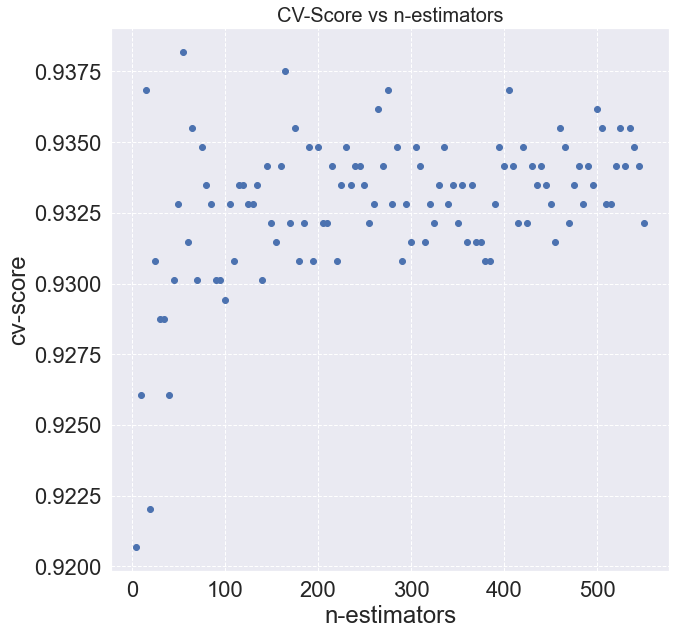

In [92]:
# Visualize effect of depth of forest
plt.rcParams["figure.figsize"] = [10, 10]
plt.title('CV-Score vs n-estimators', size=20)
plt.xlabel('n-estimators')
plt.ylabel('cv-score')
plt.scatter(eval_rf_df.index, eval_rf_df['test_score'])
plt.grid(visible=True, linestyle = '--')
plt.show()


In [72]:
# use selected depth of forest and make predictions
rf = RandomForestClassifier(n_estimators=300)
fit = rf.fit(X_train, y_train)
prediction = rf.predict(X_test)

Text(56.5, 0.5, 'Predicted Label')

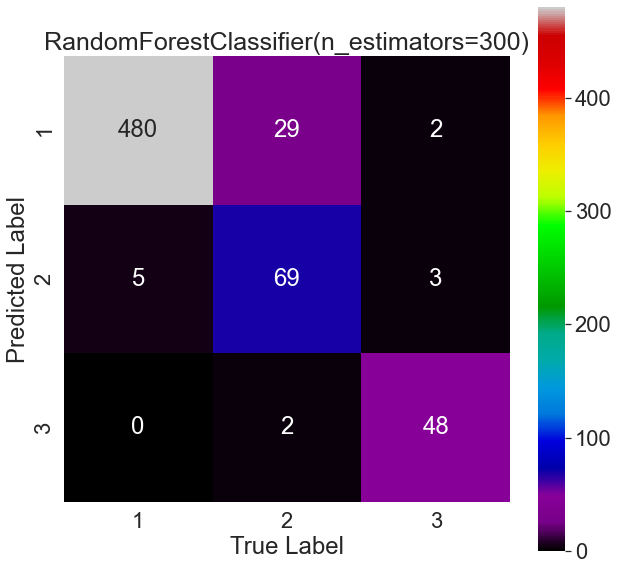

In [79]:
# confusion matrix of model colorized by count quantity
conf_mat = confusion_matrix(y_test , prediction)
sns.heatmap(conf_mat.T, 
            square=True, 
            annot=True, 
            fmt='d',
            cmap= "nipy_spectral",
            xticklabels = np.arange(1,4), 
            yticklabels = np.arange(1,4)
           )
sns.set(font_scale=2)
plt.rcParams["figure.figsize"] = [10, 10]
plt.title('RandomForestClassifier(n_estimators=300)', size=25)
plt.xlabel("True Label")
plt.ylabel('Predicted Label')


In [88]:
selection = SelectFromModel(rf)
selection.fit(X_train, y_train)

selected_features= X_train.columns[(selection.get_support())]

selected_features

Index(['baseline value', 'prolongued_decelerations',
       'abnormal_short_term_variability'],
      dtype='object')

In [100]:
# set traing parameters using min best features.
X_min_feat = X_train[selected_features[0:3]]
fit_min_feat = rf.fit(X_min_feat, y_train)
prediction_min_feat = rf.predict(X_test[selected_features[0:3]])

# set traing parameters using best 6 features.
X_6_feat = X_train[selected_features]
fit_6_feat = rf.fit(X_6_feat, y_train)
prediction_6_feat = rf.predict(X_test[selected_features])

Text(56.5, 0.5, 'Predicted Label')

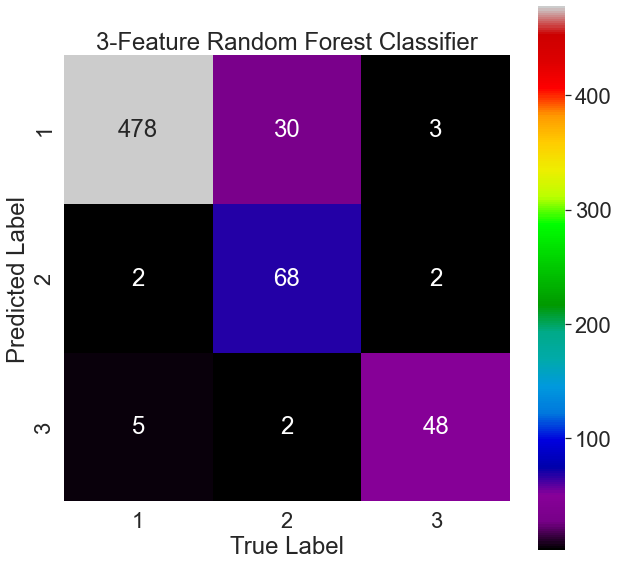

In [101]:
# confusion matrix of model colorized by count quantity
conf_mat = confusion_matrix(y_test , prediction_6_feat)
sns.heatmap(conf_mat.T, square=True, annot=True, fmt='d',cmap= "nipy_spectral",
            xticklabels = np.arange(1,4), yticklabels = np.arange(1,4))
plt.title('3-Feature Random Forest Classifier')
plt.xlabel("True Label")
plt.ylabel('Predicted Label')


Initial inspection of the confusion matrices seems to prove that a three metric evaluation can give a strong intuition for the state of the fetus.


In the data however, there is a class imbalance. Class 1 (healthy) has a much higher frequency than classes 2 (Suspect) or 3 (Pathological). To compensate for this, weighted scoring will be used.

In [103]:
# getting f1 scores. Using weighted over macro due to imbalance of classes 1:[2|3]
f1_vals = f1_score(y_test,prediction, average='weighted')
f1_vals_6 = f1_score(y_test,prediction_6_feat,average='weighted')
f1_vals_min = f1_score(y_test,prediction_min_feat,average='weighted')

# getting recall scores
rec_vals = recall_score(y_test,prediction, average='weighted')
rec_vals_6 = recall_score(y_test,prediction_6_feat,average='weighted')
rec_vals_min = recall_score(y_test,prediction_min_feat,average='weighted')

# getting precision scores
pre_vals = precision_score(y_test,prediction, average='weighted')
pre_vals_6 = precision_score(y_test,prediction_6_feat,average='weighted')
pre_vals_min = precision_score(y_test,prediction_min_feat,average='weighted')


print(f1_vals)
print(f1_vals_6)
print(f1_vals_min)
print(rec_vals)
print(rec_vals_6)
print(rec_vals_min)
print(pre_vals)
print(pre_vals_6)
print(pre_vals_min)


0.9323417546479854
0.9274341174081273
0.8460337497359658
0.9357366771159875
0.9310344827586207
0.8495297805642633
0.9342753746446794
0.9316270385021189
0.8434917304380369


### Classification Performance

| **Number of Features**  | **Precision**  |  **Recall**  |  **F1**  | 
| :----------: | :----------: | :----------: |:----------: |
| 11  | 0.9343 | 0.9357  | 0.9323 |
| 6  |  0.9316 | 0.9310  | 0.9274 |
| 3  | 0.8435 | 0.8495 | 0.8460  |


# Discussion

### Task 1
Each model ('GradientBoostingRegressor','RandomForestClassifier', 'GaussianNB', 'SVC') was able to appropriately label the multiclass data without any hyperparameter tuning. 

The models ranked as followed:  
- **Speed**: The GaussianNB model was the fastest of the four models and RandomForestClassifier was the slowest. GaussianNB was two orders of magnitude faster at training than the RandomForestClassifier.  

- **Scoring**: The RandomForestClassifier (score: 0.9315) was the best at labeling classes, and the GradientBoostingRegressor (score: 0.7406) was the worst out of the four.

<br>

### Task 2
The top features to determine the state of a fetus were: 'baseline value', 'prolongued_decelerations', 'abnormal_short_term_variability'. While the performance of the model trained was not fully optimized so it should not be used in a diagnostic setting, the metrics it uncovered could be.  
These metrics could be used by medical staff as key indicators in diagnostics and patient treatment.    Monitoring the fetal heart rate in a single office visit would be able to yield a strong intuition to the fetal health 






